In [22]:
import os

cuda_device = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device
# os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'

import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm import tqdm, trange

import random

from tensorboardX import SummaryWriter

from scipy import integrate

sns.set_style("white")
torch.cuda.is_available()

from statistics import geometric_mean


# parameters

In [23]:
# hyperparameters
tau_train = 0.01
gamma = 0.99999

h_test = 2/256
tau_test = 0.005

coe_loss = 0.0001
coe_structure = 0.00001
coe_data = 1.0
coe_regular = 0.001

coe_R = 0.1

Adam_proportion = 0.95
batch_size_LBFGS = 32

# to find the least minimum to be averaged
num_least = 3

# parameters of the Burger's equation
nu = 0.1

# the initial condition
def IC(x):
    # return -torch.sin(math.pi * x)
    return 2 * math.pi * nu * (torch.sin(math.pi * x)) / (2 + torch.cos(math.pi * x))

def exact_solution(X):
    x = X[:,0]
    t = X[:,1]
    
    return 2 * math.pi * nu * (torch.exp(- math.pi**2 * nu * t) * torch.sin(math.pi * x)) / (2 + torch.exp(- math.pi**2 * nu * t) * torch.cos(math.pi * x))

# spatial domain
x0 = -1.0
x1 = 1.0

# temporal domain
t0 = 0.0
t1 = 1.0

coe_without_R = 0.8
coe_without_R_abs = 0.25
coe_without_R_new = 0.0

coe_without_R_reg = 0.0
width_R_reg = 4
coe_regular = 0.00001

criterion = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


num_processes = 5

# param_vector = [16, 32, 64, 128]
# param_vector = [3, 5, 10, 40]
# param_vector = [2, 4, 8, 16, 32]
# param_vector = [2, 4, 8, 16, 32, 64]
param_vector = [32]
# param_vector = [4, 8, 16, 32, 64, 128, 256]
num_hidden = 1
width_R = 10
width_R_abs = 4
num_hidden_R = 1

width_R_LBFGS = 10

num_divide = 0

# param_vector = [1, 2, 4, 6, 8, 10, 12, 14, 16, 32, 64, 128]

In [24]:
def setup_seed(seed):
    
    random.seed(seed)   # Python的随机性
    os.environ['PYTHONHASHSEED'] = str(seed)    # 设置Python哈希种子，为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)   # numpy的随机性
    torch.manual_seed(seed)   # torch的CPU随机性，为CPU设置随机种子
    torch.cuda.manual_seed(seed)   # torch的GPU随机性，为当前GPU设置随机种子
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.   torch的GPU随机性，为所有GPU设置随机种子
    torch.backends.cudnn.benchmark = False   # if benchmark=True, deterministic will be False
    torch.backends.cudnn.deterministic = True

    
# the whole network is divide into two parts    

# the subnetwork followed the standard PINNs to get the solution v of the PDE 
class PDE_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(PDE_NN, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out
    
    
# the subnetwork related to the structure factor R (conservative or dissipative)    
class structure_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 1,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(structure_NN, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size, bias = True)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)
        

    def forward(self, t):
        out = self.layers(t) 
        return out
    
    
# the whole network with a output as u = R * v
# to add the regularization term, we have to give the two output separately
class NN_sidecar(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_sidecar, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)
        self.structure = structure_NN(width_R, num_hidden_R)

    def forward(self, X):
        v = self.PDE(X)
        R = self.structure(X[:,1].reshape(-1, 1))
#         print(torch.size(X[:,1]))
        return v, R
    

class NN(nn.Module):
    def __init__(self, width, num_hidden):
        super(NN, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)
        # self.structure = structure_NN()

    def forward(self, X):
        v = self.PDE(X)
#         R = self.structure(X[:,1].reshape(-1, 1))
# #         print(torch.size(X[:,1]))
#         return v, R
        # u = self.PDE(X)
        return v

# model.load_state_dict(torch.load(f"1DBurgers-Original-bs{batch_size}-epoches{epoches}-h_train{h_train}-tau_train{tau_train}-gamma{gamma}.pth"))

In [25]:
class PDE_NN_2(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 2,
            act = nn.Tanh,
        ):
        super(PDE_NN_2, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out
    
    
# the whole network with a output as u = R * v
# to add the regularization term, we have to give the two output separately
class NN_onebig(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_onebig, self).__init__()
        self.PDE = PDE_NN_2(width, num_hidden)
        # self.structure = structure_NN(width_R, num_hidden_R)

    def forward(self, X):
        u = self.PDE(X)
        # R = self.structure(X[:,1].reshape(-1, 1))
#         print(torch.size(X[:,1]))
        
        v, R = torch.unbind(u, dim=1)
        return v.reshape(-1, 1), R.reshape(-1, 1)

In [26]:
# h_test = 0.01
# tau_test = 0.005
x_test = torch.arange(-1, 1 + h_test, h_test)
t_test = torch.arange(0, 1 + tau_test, tau_test)

# lozation of training data
bc1 = torch.stack(torch.meshgrid(x_test[0], t_test, indexing='ij')).reshape(2, -1).T
bc2 = torch.stack(torch.meshgrid(x_test[-1], t_test, indexing='ij')).reshape(2, -1).T
ic = torch.stack(torch.meshgrid(x_test, t_test[0], indexing='ij')).reshape(2, -1).T
X_test_bic = torch.cat([bc1, bc2, ic]).to(device)


# the corresponding boundary and initial condition
u_bc1 = torch.zeros(len(bc1))
u_bc2 = torch.zeros(len(bc2))
u_ic = IC(ic[:, 0])
u_bic = torch.cat([u_bc1, u_bc2, u_ic]).unsqueeze(1).to(device)

# exact solution
X_test = torch.stack(torch.meshgrid(x_test, t_test, indexing='ij')).reshape(2, -1).T
X_test = X_test.to(device)
X_test.requires_grad = True

# load

-1.0596845742774967 1.065384613644847 [-1.0654032]
0.8332737869946064 0.8375853293943099 [0.83759737]
-1.1735924903771373 1.17955383788348 [-1.1795754]
1.414302786188053 1.4221867360858356 [1.4221885]
1.478015899156563 1.4855281875266408 [1.4855134]


/tmp/ipykernel_1147206/2428436267.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=15)


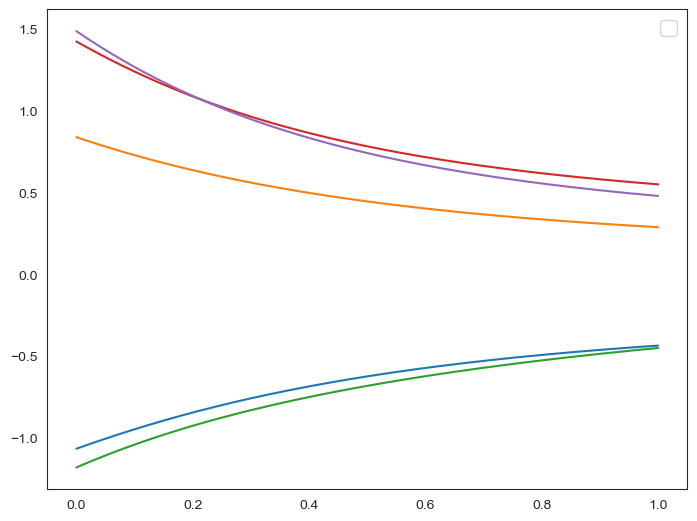

In [29]:
i = 0

fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

epoches_read = 100000
epoches = 20000
batch_size = 2046
h_train = 2/256

num_hidden = 2

num_hidden_R = 2
width_R = 8

result_matrix_reg = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    if num_divide != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN_sidecar(width, num_hidden, width_R, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/PINNs_withR/trained_model/1DBurgers-PINNs_withR-bs{batch_size}-epoches{epoches_read}-h_train{h_train}-tau_train{tau_train}-gamma{gamma}-width{width}-hidden{num_hidden}-widthR{width_R}-hiddenR{num_hidden_R}-LBFGS{Adam_proportion}-{j}.pth"))


        # self.model.eval()
        # with torch.no_grad():
        v_pred, R = model(X_test)
            
            # boundary and initial point
        v_pred_bic, R_bic = model(X_test_bic)
        # with torch.no_grad():
        #     v_pred, R = self.model(X)
        
        #     # boundary and initial point
        #     v_pred_bic, R_bic = self.model(X_bic)

        v_pred_matrix = v_pred.cpu().detach().numpy().reshape(len(x_test), len(t_test))

        

        plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)])
        # plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)], label=f"width{width}, index{j}")

        f = IC(x_test).cpu().numpy()

        # to avoid the denominator to be zero
        # create a mask to find the position of zero
        zero_denominator_mask = (v_pred_matrix[:,0] == 0)

        # replace the zero with 1 in the denominator
        R_0_temp = f / np.where(zero_denominator_mask, np.ones_like(v_pred_matrix[:,0]), v_pred_matrix[:,0])

        # reset the result of the zero position to 1
        R_0_temp[zero_denominator_mask] = 1

        # R_0_temp = f.squeeze() / v_pred_matrix[:,0]

        h = x_test[1] - x_test[0]

        # R_0_ref = np.abs(integrate.simpson(R_0_temp[:x_shock+1], x[:x_shock+1].cpu().numpy()) + integrate.simpson(R_0_temp[x_shock:], x[x_shock:].cpu().numpy())) / 2.0
        R_0_ref = integrate.romb(R_0_temp, dx = h.cpu().numpy()) / 2.0

        u_0 = f

        Q_0 = integrate.romb(u_0**2, dx = h.cpu().numpy())

        v_0_integral = integrate.romb(v_pred_matrix.T ** 2, dx = h.cpu().numpy(), axis = 1)[0]

        R_0_ref_2 = np.sqrt(Q_0/v_0_integral)

        print(R_0_ref, R_0_ref_2, R[0].cpu().detach().numpy())

    i += 1


plt.legend(fontsize=15)


-0.3794335463634194 0.38141605169811815 [-0.38136345]
0.3592307404053412 0.36111523007309854 [0.36106616]
-0.4043491914063487 0.4068987793924251 [-0.40679827]
0.4687155326268626 0.4712798263346626 [0.4711333]
0.49632256565398586 0.4989075070477331 [0.4987331]


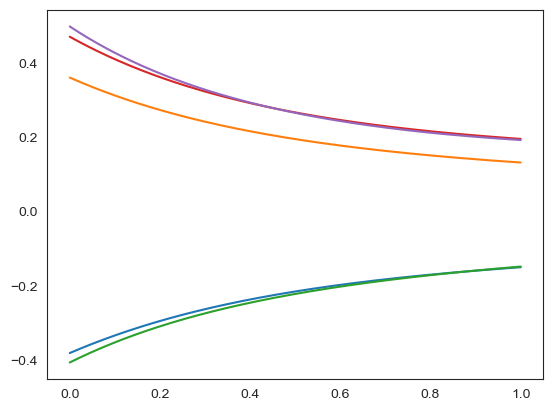

In [30]:
i = 0

batch_size_64 = 2046
width_R = 8
h_train_romb = 2/256
coe_structure_after = 1.0
coe_data = 1.0
num_hidden = 2
epoches = 20000
epoches_read = 50000
num_hidden_R = 2
learning_rate = 0.00001

result_matrix_after2 = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    for j in range(num_processes):

        # model = NN(width, num_hidden).to(device)
        model = NN_sidecar(width, num_hidden, width_R, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/sidecar_after/trained_model/1DBurgers-R0-noR{coe_without_R_new}-bs{batch_size_64}-epoches{epoches}-epoches_read{epoches_read}-h_train{h_train_romb}-tau_train{tau_train}-gamma{gamma}-coe_structure{coe_structure_after}-coe_data{coe_data}-width{width}-hidden{num_hidden}-widthR{width_R}-hidden_R{num_hidden_R}-LBFGS{Adam_proportion}-lr{learning_rate}-{j}.pth"))


        # self.model.eval()
        # with torch.no_grad():
        # u_pred = model(X_test)
            
        #     # boundary and initial point
        # u_pred_bic = model(X_test_bic)
        # with torch.no_grad():
        v_pred, R = model(X_test)
        
            # boundary and initial point
        v_pred_bic, R_bic = model(X_test_bic)


        plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)])


        v_pred_matrix = v_pred.cpu().detach().numpy().reshape(len(x_test), len(t_test))
        
            
        f = IC(x_test).cpu().numpy()

        # to avoid the denominator to be zero
        # create a mask to find the position of zero
        zero_denominator_mask = (v_pred_matrix[:,0] == 0)

        # replace the zero with 1 in the denominator
        R_0_temp = f / np.where(zero_denominator_mask, np.ones_like(v_pred_matrix[:,0]), v_pred_matrix[:,0])

        # reset the result of the zero position to 1
        R_0_temp[zero_denominator_mask] = 1

        # R_0_temp = f.squeeze() / v_pred_matrix[:,0]

        h = x_test[1] - x_test[0]

        # R_0_ref = np.abs(integrate.simpson(R_0_temp[:x_shock+1], x[:x_shock+1].cpu().numpy()) + integrate.simpson(R_0_temp[x_shock:], x[x_shock:].cpu().numpy())) / 2.0
        R_0_ref = integrate.romb(R_0_temp, dx = h.cpu().numpy()) / 2.0

        u_0 = f

        Q_0 = integrate.romb(u_0**2, dx = h.cpu().numpy())

        v_0_integral = integrate.romb(v_pred_matrix.T ** 2, dx = h.cpu().numpy(), axis = 1)[0]

        R_0_ref_2 = np.sqrt(Q_0/v_0_integral)

        print(R_0_ref, R_0_ref_2, R[0].cpu().detach().numpy())



    i += 1



# plot